In [1]:
!pip install sentence-transformers langchain faiss-cpu openai pinecone-client

In [2]:
OPENAI_API_KEY=""

In [3]:
import sys
sys.path.append("..")
from vekta_testa import runner, utils

In [4]:
import pandas as pd
import json
from langchain.docstore.document import Document

# Dataset adapted from: https://www.kaggle.com/datasets/juhibhojani/house-price
data = pd.read_csv('indian_real_estate.csv')

# Grab the value we will be searching for out of the dataset
chosenIndex = data.iloc[284]
clean_value = {key: value for key, value in chosenIndex.to_dict().items() if value is not None and not pd.isna(value)}
clean_doc = Document(page_content=json.dumps(clean_value), metadata={})

# Shuffle the dataset to mix cities
shuffled = data.sample(frac=1).reset_index(drop=True)

properties = [clean_doc]
for index, row in shuffled.iterrows():
    # Clean out the empty data
    clean_row = {key: value for key, value in row.to_dict().items() if value is not None and not pd.isna(value)}
    json_string = json.dumps(clean_row)
    doc = Document(page_content=json_string, metadata={})
    properties.append(doc)

In [5]:
properties[0]

Document(page_content='{"Unnamed: 0": 284, "Index": 284, "Title": "2 BHK Ready to Occupy Flat for sale in Swastik Alps Thane West", "Description": "Thane West, Thane has an appealing 2 BHK flat for sale with various amenities. Situated in the excellent Swastik Alps township. The flat enjoys a prime location. This is a desirable apartment for resale. You can buy this ready to move flat in Thane West at a reasonable price of INR 1.20 Cr. You will find it semi-furnished.", "Price (in rupees)": 10573.0, "Location": "thane", "Status": "Ready to Move", "Furnishing": "Semi-Furnished", "Society": "Swastik Alps", "Bathroom": "2", "Super Area": "1135 sqft"}', metadata={})

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

tableModel = HuggingFaceEmbeddings(model_name="deepset/all-mpnet-base-v2-table", encode_kwargs=encode_kwargs )
table_index = FAISS.from_documents(properties[:2000], tableModel)

In [7]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import FAISS

model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bgeModel = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-base-en", model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)
faiss_index_bge = FAISS.from_documents(properties[:2000], bgeModel)

In [8]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

oaiEmbeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
faiss_index_openai = FAISS.from_documents(properties[:2000], oaiEmbeddings)
# faiss_index_openai.similarity_search_with_score('apartment', k=1001)[0]

In [9]:
import json
def find_id(entries, target_id):
    for index, (entry, score) in enumerate(entries):
        if str(entry['Index']) == target_id:
            # print('id found')
            return index
    return -1

def find_id_pinecone(entries, target_id):
    for index, (entry, score) in enumerate(entries):
        # print('-', json.loads(entry.page_content)['Index'], '<', target_id, json.loads(entry.page_content)['Index'] == target_id)
        if str(json.loads(entry.page_content)['Index']) == target_id:
            # print('id found')
            return index
    return -1

In [10]:
# Update values from langchain to vekta_testa format
def post_processor(scenario, scored_values):
    processor_results = []
    for index, (entry, score) in enumerate(scored_values):
        value = json.loads(entry.page_content)
        processor_results.append((value, score))
    return processor_results

In [11]:
results = runner.run_vecta_tests(
    [
        runner.EmbeddingIndex(
            index_name='openai',
            search_function=lambda scenario: faiss_index_openai.similarity_search_with_score(scenario, k=900),
            find_result=lambda values, target: find_id(values, target),
            post_processor=lambda scenario, scored_values: post_processor(scenario, scored_values)
        ),
        runner.EmbeddingIndex(
            index_name='deepset/all-mpnet-base-v2-table',
            search_function=lambda scenario: table_index.similarity_search_with_score(scenario, k=900),
            find_result=lambda values, target: find_id(values, target),
            post_processor=lambda scenario, scored_values: post_processor(scenario, scored_values)
        ),
        runner.EmbeddingIndex(
            index_name='BAAI/bge-large-en',
            search_function=lambda scenario: faiss_index_bge.similarity_search_with_score(scenario, k=900),
            find_result=lambda values, target: find_id(values, target),
            post_processor=lambda scenario, scored_values: post_processor(scenario, scored_values)
        ),
    ],
    [
        runner.Testcase(
            case_id='0-control',
            scenario="kimchi"
        ),
        runner.Testcase(
            case_id='1-exact',
            scenario="Thane has an appealing 2 BHK flat for sale with various amenities. Situated in the excellent Swastik Alps township."
        ),
        runner.Testcase(
            case_id='2-partial',
            scenario="Thane has an appealing 2 BHK flat for sale with various amenities. It's located in the exquisite township near the mountains."
        ),
        runner.Testcase(
            case_id='3-other-words',
            scenario='Offers a charming two bedroom apartment available, equipped with numerous features. Located in the prime Swastik Heights community.'
        ),
        runner.Testcase(
            case_id='4-location',
            scenario='Apartment in Swastik Alps town'
        ),
        runner.Testcase(
            case_id='5-negative',
            scenario='apartment in the alps, without a terrace'
        ),
        runner.Testcase(
            case_id='6-price-beds',
            scenario='apartment for under 11000 rupees with 2 bedrooms'
        )
    ],
    '284'
)

Starting test -  0-control
Starting test -  1-exact
Starting test -  2-partial
Starting test -  3-other-words
Starting test -  4-location
Starting test -  5-negative
Starting test -  6-price-beds


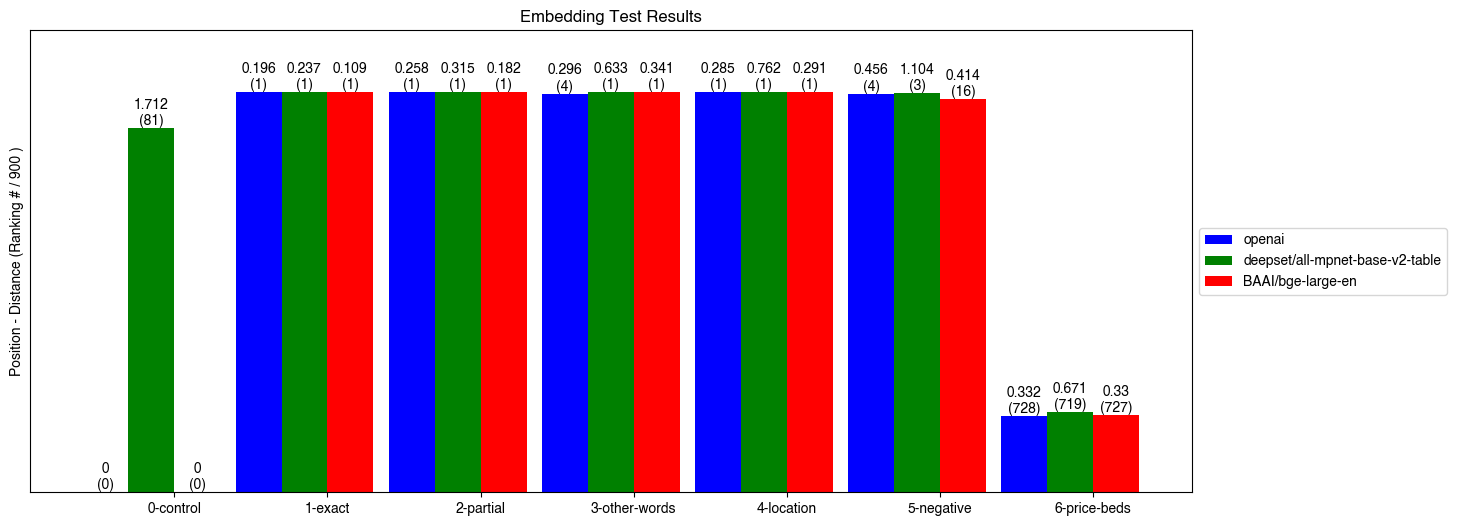

In [12]:
from vekta_testa.graph import plot_results

plot_results(results, {
        'openai': 'b',
        'deepset/all-mpnet-base-v2-table': 'g',
        'BAAI/bge-large-en': 'r',
    },
    900
)

In [26]:
utils.tabularize_results(
    results,
    '3-other-words',
    0,
    lambda value, score: [value["Index"], score, value["Description"]]
)

,0,1,2
0,7135,0.284892,"Up for immediate sale is a 3 BHK apartment in Vaishnodevi Circle, Ahmedabad. Don't miss this bargain flat for sale. This flat is situated in the Swastik Riviera township and is equipped with premium facilities. This flat is an attractive property for resale. This ready to move flat is offered at an economical price of INR 65 Lac. This flat is an ideal choice because it is an unfurnished apartment with all basic amenities. The property is strategically placed near prominent places as gandhinagar are close by to tragad and with several schools, hospitals which make for the smooth living of residents."
1,6115,0.285330,"Up for immediate sale is a 3 BHK apartment in Vaishnodevi Circle, Ahmedabad. Don't miss this bargain flat for sale. This flat is situated in the Swastik Riviera township and is equipped with premium facilities. This flat is an attractive property for resale. This ready to move flat is offered at an economical price of INR 65 Lac. This flat is an ideal choice because it is an unfurnished apartment with all basic amenities. The property is strategically placed near prominent places as gandhinagar are close by to tragad and with several schools, hospitals which make for the smooth living of residents."
2,6805,0.286081,"Up for immediate sale is a 3 BHK apartment in Vaishnodevi Circle, Ahmedabad. Don't miss this bargain flat for sale. This flat is situated in the Swastik Riviera township and is equipped with premium facilities. This flat is an attractive property for resale. This ready to move flat is offered at an economical price of INR 65 Lac. This flat is an ideal choice because it is an unfurnished apartment with all basic amenities. The property is strategically placed near prominent places as gandhinagar are close by to tragad and with several schools, hospitals which make for the smooth living of residents."
3,284,0.296372,"Thane West, Thane has an appealing 2 BHK flat for sale with various amenities. Situated in the excellent Swastik Alps township. The flat enjoys a prime location. This is a desirable apartment for resale. You can buy this ready to move flat in Thane West at a reasonable price of INR 1.20 Cr. You will find it semi-furnished."
4,129828,0.323425,"Have a look at this immaculate 3 BHK flat for sale in Dwarka Sector 10, New Delhi. Well-tucked in the Madhur Jeevan Apartment township, the property is easily accessible. This flat is available as a resale property. You can buy this ready to move flat in Dwarka Sector 10 at a reasonable price of INR 2.10 Cr. This contemporary apartment is semi-furnished. The property is constructed with proximity to major landmarks like near by market and metro station."
5,125418,0.323840,"Have a look at this immaculate 3 BHK flat for sale in Dwarka Sector 10, New Delhi. Well-tucked in the Madhur Jeevan Apartment township, the property is easily accessible. This flat is available as a resale property. You can buy this ready to move flat in Dwarka Sector 10 at a reasonable price of INR 2.10 Cr. This contemporary apartment is semi-furnished. The property is constructed with proximity to major landmarks like near by market and metro station."
6,129258,0.324302,"Have a look at this immaculate 3 BHK flat for sale in Dwarka Sector 10, New Delhi. Well-tucked in the Madhur Jeevan Apartment township, the property is easily accessible. This flat is available as a resale property. You can buy this ready to move flat in Dwarka Sector 10 at a reasonable price of INR 2.10 Cr. This contemporary apartment is semi-furnished. The property is constructed with proximity to major landmarks like near by market and metro station."
7,124938,0.324702,"Have a look at this immaculate 3 BHK flat for sale in Dwarka Sector 10, New Delhi. Well-tucked in the Madhur Jeevan Apartment township, the property is easily accessible. This flat is available as a resale property. You can buy this ready to move flat in Dwarka Sector 10 at a reasonable price of INR 2.10 Cr. This contemporar

In [27]:
utils.tabularize_results(
    results,
    '3-other-words',
    1,
    lambda value, score: [value['Index'], score, value['Description']]
)

,0,1,2
0,284,0.632599,"Thane West, Thane has an appealing 2 BHK flat for sale with various amenities. Situated in the excellent Swastik Alps township. The flat enjoys a prime location. This is a desirable apartment for resale. You can buy this ready to move flat in Thane West at a reasonable price of INR 1.20 Cr. You will find it semi-furnished."
1,172856,0.669834,"Up for immediate sale is a 2 BHK apartment in Lunsikui, Navsari. Don't miss this bargain flat for sale. This flat all equipped with required facilities, is up for resale. The ready to move flat in the prime area of Lunsikui is available at a reasonable price of INR 25 Lac. The spacious apartment is unfurnished. Landmarks near the apartment include garden,hospital and hotel."
2,172705,0.693448,This ready to move-in 1 BHK flat is available for sale at the premium Shramik Nagar in Nashik. This flat is an attractive property for resale. This ready to move flat in Shramik Nagar comes at an affordable price of INR 17 Lac. The spacious apartment is semi-furnished.
3,149080,0.705848,"Creatively planned and constructed is a 2 BHK flat for sale in Vadagoan, Belgaum. This flat for resale has a desirable location. This apartment in one of the significant areas of Vadagoan is ready to move, and can be purchased at the best price of INR 58 Lac. The flat is uniquely designed to enhance the living style. It is furnished, studded with all the basic facilities. Some nearby landmarks are all basic civic amenities available at ease."
4,151252,0.709764,"This gorgeous 2 BHK Flat is available for sale in Zirakpur, Chandigarh. Strategically situated in the Sushma Green Vista site, it is placed at a prime location. Your hunt for the perfect apartment for resale comes to an end here. The ready to move flat in Zirakpur is all ready for sale at a low-priced budget of INR 43.5 Lac. This flat is an ideal choice because it is an semi-furnished apartment with all basic amenities. old ambala road, dhakoli zirakpur are some of the well-known landmarks in this locality."
5,304,0.717408,"Up for immediate sale is a 2 BHK apartment in Panch Pakhdi, Thane. Don't miss this bargain flat for sale. It is housed in the well-planned Samrin Heritage township in an advantageous location. Invest your valuable money in this flat that is for sale. In Panch Pakhdi, this ready to move flat is available at an attractive price of INR 1.76 Cr. The apartment's possession date is Jun '23. You will find it unfurnished. The property is strategically placed near prominent places as viviana mall,jupiter hospital,korum mall which make for the smooth living of residents."
6,147283,0.720205,"This exquisite 1 BHK Flat is offered for sale in Pokharan Road Number 2, Thane. Ideally situated in the Tata Serein township it enjoys a prime location. This flat is an attractive property for resale. This ready to move flat located in Pokharan Road Number 2 is available for purchase at a fair price of INR 1.10 Cr. This unfurnished flat is strategically designed with all the amenities to enhance the living experience. behind laxmi complex are some major landmarks near the apartment."
7,162276,0.729926,"This magnificent 3 BHK Flat is available for sale in Eta 2, Greater Noida. This flat is situated within the renown township of Ska Metro Ville. This is one of the best properties available for resale. In Eta 2, this ready to move flat is available at an attractive price of INR 80 Lac. This flat is an ideal choice because it is an semi-furnished apartment with all basic amenities. The property is constructed with proximity to major landmarks like ska metro ville is a very good society nd near by market,school,metro."
8,144363,0.730948,"Up for immediate sale is a 2 BHK apartment in Wanowrie, Pune. Don't miss this bargain flat for sale. Strategically situated in the Utopia Chs site, it is placed at a prime location. This flat is available as a resale property. This apartment in one of the significant areas of Wanowrie is ready to move, and can be